In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib import animation, rc
rc('animation', html='jshtml')
from matplotlib import cm
from matplotlib import gridspec

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("axes", labelsize=20, titlesize=20)
plt.rc("xtick", labelsize=18, top=True, direction="in")
plt.rc("ytick", labelsize=18, right=True, direction="in")
plt.rc("legend", fontsize=18)

In [70]:
def cost_func(pop):
    """
    Computes the Z-vals for the 2D non-convex Rastrigin-function

    Returns:
        Z-vals = numpy array of shape (N,) where N = N_pop
    """
    A = 10.0
    dim1 = np.power(pop[:,0],2)-A*np.cos(2.0*np.pi*pop[:,0])
    dim2 = np.power(pop[:,1],2)-A*np.cos(2.0*np.pi*pop[:,1])
    return np.array(2.0*A+dim1+dim2)


class ContinuousGeneticAlgorithm:
    def __init__(self, cost_func, N_params, p_lo, p_hi, N_pop=12, 
                 mutation_rate = 0.2, selection_rate=0.5, N_generations = 100, acc = 0.01):

        self.cost_func      = cost_func
        self.N_params       = N_params
        self.p_lo           = p_lo
        self.p_hi           = p_hi
        self.N_pop          = N_pop
        self.mutation_rate  = mutation_rate
        self.selection_rate = selection_rate
        self.N_generations  = N_generations
        self.acc            = acc

        self.current_pop = self.init_random_population()
        self.N_keep = int(2*np.ceil(self.selection_rate*self.N_pop/2))
        """ N_keep has to be an equal number due to the fact that parents
            is picked in sets of 2 from N_keps part of the
            population.  """
        self.history = []
        """An attribute to store the decoded population at 
           each generation of the chosen nr. of iterations"""
        self.best_chromosomes = []
        """An attribute to store the strongest chromosome 
           at the end of each generation in a simulation"""
        self.N_iterations = 0
        """An attribute to keep track of the number of 
           iterations in simulate before convergence"""

    def init_random_population(self):
        """ 
        Computes the inital population as a collection of 'Chromosomes' each
        represented by N_param length of floating point values.
        
        Returns:
            init_pop: numpy array of shape (N , K) with N = N_pop, K = N_params
        """
        return np.array([np.random.uniform(low=0.0, high=1.0, size=self.N_params) for i in range(self.N_pop)])
    
    def decode_chromosome(self,chromosome):
        """ 
        Decodes the normed floating point representation of the chromosome according to 
        eq. (3.5) from Randy L. Haupt, Sue Ellen Haupt - Practical Genetic Algorithms (2004)
        s.t. 0 < bit_string_i < 1
        
        Returns:
            decoded_chromosome: numpy array of shape (N,)  with N = N_params
        """
        q_s = []
        for i in range(len(chromosome)):
            q_s.append(chromosome[i]*(self.p_hi-self.p_lo)+self.p_lo)
        return np.array(q_s)

    def decode_population(self):
        """ 
        Decodes the binary representation of the chromomes in the population into
        a floating point decimal representation, s.t. 0 < bit_string_i < 1
        
        Returns:
            decoded_population: numpy array of shape (N , K), with N = N_pop, K = N_params
        """
        population = self.current_pop
        decoded_population = []
        for i in range(population.shape[0]):
            decoded_chromosome = self.decode_chromosome(population[i])
            decoded_population.append(decoded_chromosome)
        return np.array(decoded_population)

    def population_cost(self):
        """ 
        Computes the cost of the current population.
        I.e. the i'th entry in pop_costs corresponds to the cost of the i'th chromosome 
        in the population:
            
        pop_costs = [cost(chromosome_1),cost(chromosome_2),...,cost(chromosome_(N_pop))]
        
        Returns:
            pop_costs: numpy array of shape (N,) with N = N_pop
        """
        return self.cost_func(self.decode_population())
    
    def sort_population(self):
        """ 
        Sorting the population according the cost of each chromosome
        in ascending order.

        """
        collective = np.append(self.current_pop,np.vstack(self.population_cost()),axis=1)
        collective = collective[collective[:, collective.shape[1]-1].argsort()]
        self.current_pop = np.array([collective[i][0:collective.shape[1]-1] for i in range(collective.shape[0])])
        
    def natural_selection(self):
        """ 
        Performing natural selection on the population according to the 
        selection_rate, such that N_keep = round(N_pop*selection_rate)
        and the worst 'N_pop-N_keep' number of chromosomes is deleted from
        the population.
    
        """
        self.current_pop = self.current_pop[0:self.N_keep]

    def crossover_mating(self,parents):
        """
        Creating two new 'Offspring' (chromosomes), from the two parents
        according to the extrapolation/crossover-technique presented
        through eqs.: (3.12), (3.13), (3.14) and (3.15)
        from Randy L. Haupt, Sue Ellen Haupt - Practical Genetic Algorithms (2004)

        Returns:
            offspring: numpy array of shape (2, N) where N = N_params

        """
        parent1, parent2 = parents[0], parents[1]
        crossover_point = np.random.randint(self.N_params)
        offspring1 = np.append(parent1[:crossover_point],parent2[crossover_point:])
        offspring2 = np.append(parent2[:crossover_point],parent1[crossover_point:])
        for i in range(crossover_point,self.N_params):
            beta = np.random.uniform(low=0.0, high=1.0)
            offspring1[i] = parent1[i]-beta*(parent1[i]-parent2[i])
            offspring2[i] = parent2[i]+beta*(parent1[i]-parent2[i])
        return np.array([list(offspring1),list(offspring2)])

    def pair_selection(self,method='top-down'):
        """
        Selecting two of the N_keep chromosomes according to the 
        chosen method.
        
        """
        parrents = []
        if method == 'top-down':
            for i in range(int(np.ceil(self.N_keep/2))):
                parent_1 = list(self.current_pop[2*i:2*i+2][0])
                parent_2 = list(self.current_pop[2*i:2*i+2][1])
                parrents.append([parent_1,parent_2])
                if len(parrents) >= self.N_pop-self.N_keep:
                    break
        if method == 'random-pairing':
            for i in range(int(np.ceil(self.N_keep/2))):
                parent_1 = list(self.current_pop[int(np.floor(self.N_keep*np.random.uniform()))])
                parent_2 = list(self.current_pop[int(np.floor(self.N_keep*np.random.uniform()))])
                parrents.append([parent_1,parent_2])
                if len(parrents) >= self.N_pop-self.N_keep:
                    break

        return parrents

    def mating(self,parents):
        """
        Creating 'offspring' until N_pop-N_keep offspring is created and then 
        adding offspring to population
        
        """
        offspring = []
        for i in range(len(parents)):
            current_offspring = self.crossover_mating(parents[i])
            offspring.append(list(current_offspring[0])), offspring.append(list(current_offspring[1]))
            if len(offspring) >= self.N_pop-self.N_keep:
                break
        offspring = np.array(offspring)
        self.current_pop = np.append(self.current_pop,offspring[:self.N_pop-self.N_keep],axis=0)

    def mutate(self):
        """ 
        Mutating mutation_rate fraction of the total number of bits in the
        population, by inverting bits 0 --> 1 and 1 --> 0.

        The chromosome_index is generated to avoid mutating the best 
        chromosome, i.e. only random integers in [1;N_pop[
        The bit_index = random integers in [0;N_params*N_bits[
        
        """
        total_nr_bits = self.N_pop*self.N_params
        N_mutations   = round(total_nr_bits*self.mutation_rate)

        chromosome_index = np.random.randint(1,self.N_pop,size=N_mutations)
        bit_index        = np.random.randint(0,self.N_params,size=N_mutations)

        for i in range(N_mutations):
            self.current_pop[chromosome_index[i]][bit_index[i]] = np.random.uniform(low=0.0, high=1.0)

    
    def simulate(self):
        """ 
        Running the simulation N_generations number of 
        times, or until wanted accuracy is acchieved.

        Furthermore the decoded_population and 
        best chromosome at each generation is stored. 
        
        """
        self.sort_population() 
        #print(f'cost = {self.population_cost()}')              
        self.history.append(self.decode_population())
        self.best_chromosomes.append(self.history[-1][0])
        for i in range(self.N_generations):
            self.natural_selection()             
            self.mating(test.pair_selection(method='random-pairing'))   
            self.mutate()
            self.sort_population()   
            self.history.append(self.decode_population())
            self.best_chromosomes.append(self.history[-1][0])
            self.N_iterations += 1
            if self.cost_func(np.array([list(test.best_chromosomes[-1])])) < self.acc:
                break
        print(f'Went through {self.N_iterations} generations')
  
test = ContinuousGeneticAlgorithm(cost_func=cost_func, N_params=2, p_lo=-5.12, p_hi=5.12, N_pop=12, 
                                  mutation_rate = 0.2, selection_rate=0.5, N_generations = 1000, acc = 0.1)       
test.simulate()

Went through 141 generations


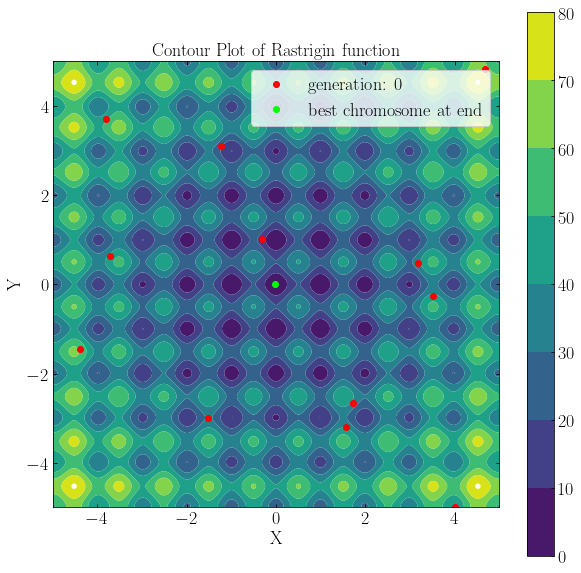

In [87]:
## https://en.wikipedia.org/wiki/Test_functions_for_optimization

### Defining Himmelblau function ###
def f(x,y):
    return np.power((np.power(x,2)+y-11),2)+np.power((x+np.power(y,2)-7),2)

## Defining Rosenbrock function ##
def f2(x,y):
    return np.power(1-x,2)+100.0*np.power(y-np.power(x,2),2)

## Defining 2D Rastrigin function ##
def f3(x,y):
    A = 10.0
    dim1 = np.power(x,2)-A*np.cos(2.0*np.pi*x)
    dim2 = np.power(y,2)-A*np.cos(2.0*np.pi*y)
    return 2.0*A+dim1+dim2

## Defining Ackley function ##
def f4(x,y):
    fac1 = -20.0*np.exp(-0.2*np.sqrt(0.5*(np.power(x,2)+np.power(y,2))))
    fac2 = -np.exp(0.5*(np.cos(2.0*np.pi*x)+np.cos(2.0*np.pi*y)))
    return fac1+fac2+np.exp(1.0)+20.0

                    ###############################################################################
                    #################### Creating Contour plot of function ########################
                    ###############################################################################


## Defining x- & y-limits for plot ##
xlims, ylims = [-5.0,5.0], [-5.0,5.0]

## Determining levels in function: i.e. Z = 0, 1, 4, 10.... ## (for himmelblau)
levels = [0,1,4,10,15,20,40,60,80,110,150,200,300,400,500,600,700,1000]

## Determining levels in function: i.e. Z = 0, 1, 4, 10.... ## (for rosenbrock)
levels2 = [0,1,4,10,15,20,40,60,80,110,150,200,300,400,500,600,700,1000]

## Determining levels in function: i.e. Z = 0, 1, 4, 10.... ## (for rastrigin)
levels3 = [0,10,20,30,40,50,60,70,80]

## Determining levels in function: i.e. Z = 0, 1, 4, 10.... ## (for ackley)
levels4 = [0,2,4,6,8,10,12,14,16]

## Setting values for plot ##
xlist = np.linspace(xlims[0],xlims[1],1000)
ylist = np.linspace(ylims[0],ylims[1],1000)
X, Y = np.meshgrid(xlist,ylist)
Z = f3(X,Y)

## Defining plot ##
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_title('Contour Plot of Rastrigin function',size=18)
contour_plot = ax.contourf(X,Y,Z, levels3, antialiased=True,cmap=cm.viridis) # prøv: cmap=cm.viridis
fig.colorbar(contour_plot)
ax.set_xlim(xlims[0],xlims[1]), ax.set_ylim(ylims[0],ylims[1])
ax.set_xlabel("X",size=18), ax.set_ylabel("Y",size=18)
#ax.grid()

ax.plot(test.history[0][:,0],test.history[0][:,1],'ro',label='generation: 0')
ax.plot(test.best_chromosomes[-1][0],test.best_chromosomes[-1][1],'o',color='lime',label='best chromosome at end')
ax.set_aspect('equal', adjustable='box')
ax.legend(loc='upper right')
plt.show()

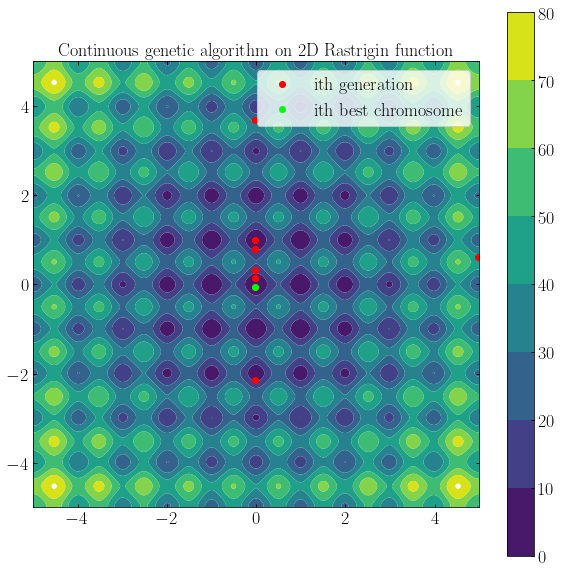

In [85]:
## Sorting out every 'x'th generation to animate ##
counter = 0
history, best_chromosomes = [], []
for i in range(len(test.history)):
    if counter == int(np.floor(len(test.history)/11)):
        history.append(test.history[i])
        best_chromosomes.append(test.best_chromosomes[i])
        counter = 0
    counter += 1

## Defining plot ##
## Defining x- & y-limits for plot ##
xlims, ylims = [-5.0,5.0], [-5.0,5.0]
xlist = np.linspace(xlims[0],xlims[1],1000)
ylist = np.linspace(ylims[0],ylims[1],1000)
X, Y = np.meshgrid(xlist,ylist)
Z = f3(X,Y)

fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_title('Continuous genetic algorithm on 2D Rastrigin function',size=18)

contour_plot = ax.contourf(X,Y,Z, levels3, antialiased=True,cmap=cm.viridis) # prøv: cmap=cm.viridis
fig.colorbar(contour_plot)

generations, = ax.plot([],[],'o',color='r',label='ith generation')
best_chromosome, = ax.plot([],[],'o',color='lime',label='ith best chromosome')


def update(i):
    generations.set_data(history[i][:,0],history[i][:,1])
    best_chromosome.set_data(best_chromosomes[i][0],best_chromosomes[i][1])

    return generations, best_chromosome,


ax.set_xlim(xlims[0],xlims[1])
ax.set_ylim(ylims[0],ylims[1])
ax.set_aspect('equal', adjustable='box')
ax.legend(loc = 'upper right')
anim = animation.FuncAnimation(fig,
                               update,
                               frames=10,
                               interval=1000,
                               blit=True,
                               repeat_delay=1000)
# Set up formatting for the movie files

## uncomment below to save gif ##
#writergif = animation.PillowWriter(fps=3) 
#anim.save("ContinuousGA.gif", writer=writergif)

anim